Calling initialize
	Initialization Time: 0.213274002075
Radius:  15
103  stations 32361  points
Calling main
Finishing step: 0
Finishing step: 5000
Finishing step: 10000
Finishing step: 15000
Finishing step: 20000
Finishing step: 25000
Finishing step: 30000
Total Time 70.7433400154
Pre loop Time 0.00053882598877
Inner loop time 70.3053042889
Outer loop time 0.317478656769
Plotting results


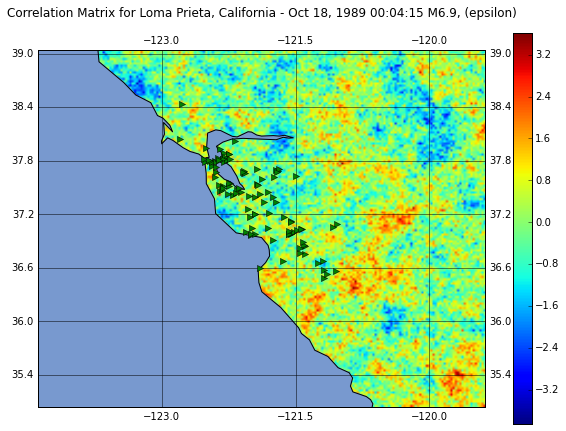

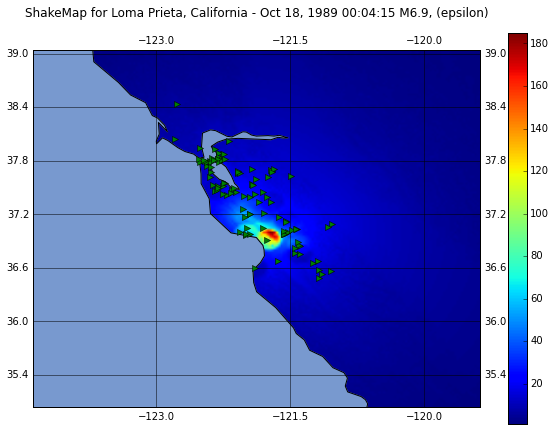

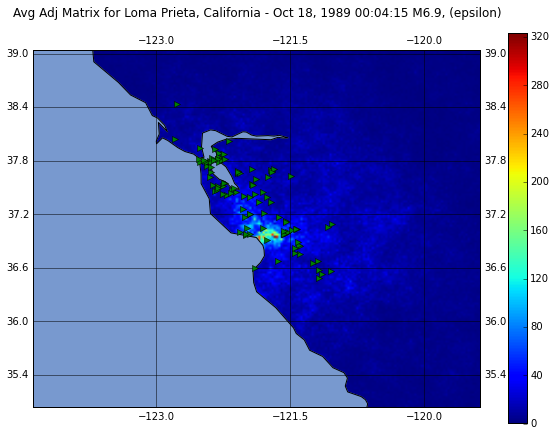

In [1]:
#######################################################
# Code for computing the spatial correlation for a ShakeMap,
# adding to a ShakeMap grid, and computing multiple realizations
# VARIABLES:
#     voi - variable of interest, i.e. PGA
#     r - radius of influence
#     num_realization- integer for desired number of realizations
#     corr_model- JB2009 or GA2010
#     vs_corr- Vs30 correlated bool, see JB2009
#     input data- grid.xml, uncertainty.xml, and stationlist.xml
#         stored in Inputs directory
#######################################################
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from neicio.readstation import readStation
from neicio.shake import ShakeGrid
from neicio.gmt import GMTGrid
import time
from matplotlib import cm
import sys
sys.path.append('/Users/sverros/Documents/Modules')
from Correlation.setup import initialize
from Correlation.loop import main
from Correlation.realizations import realizations
from Correlation.plotting import plot
                                                                                                                                                                                                 
voi = 'PGA'
r = [15]
num_realizations = 0
cor_model = 'GA2010'
vscorr = True
plot_on = True

for R in range(0,np.size(r)):
    radius = r[R]
    # Get shakemap for desired variable, PGA, uncertainty grid and stationdata
    shakemap = ShakeGrid('Inputs/grid.xml', variable = '%s' % voi)

    # Uncertainty Data: Units in ln(pctg)
    unc_INTRA = ShakeGrid('Inputs/uncertainty.xml', variable= 'GMPE_INTRA_STD%s' % voi)
    unc_INTER = ShakeGrid('Inputs/uncertainty.xml', variable= 'GMPE_INTER_STD%s' % voi)
    
    # Station Data: Units in pctg
    stationlist = 'Inputs/stationlist.xml'
    stationdata = readStation(stationlist)

    print 'Calling initialize'
    variables = initialize(shakemap, unc_INTRA, unc_INTER, stationdata)

    print 'Radius: ', radius
    print variables['K'], ' stations', variables['N']*variables['M'], ' points'

    rand = []
    f = open('rand.txt', 'r')
    for i in range(0,variables['N']*variables['M']):
        rand.append(float(f.readline()))
    
#    rand = np.random.randn(variables['N']*variables['M'])
    # Truncate to +/- 3 sigma
#     for i in range(0,variables['N']*variables['M']):
#         if abs(rand[i]) > 3:
#             rand[i] = (6-np.sign(rand[i])*rand[i])
    
    print 'Calling main'
    out = main(variables, r, voi, rand, cor_model, vscorr)
    
    if num_realizations > 0:
        print 'Computing realizations'
        realizations(num_realizations, radius, variables['N'], variables['M'], out['grid_arr'],
                 out['mu_arr'], out['sigma_arr'], variables['uncertaintydata'], out['data'])

    if plot_on == True:
        print 'Plotting results'
        plot(out, variables, voi, shakemap, stationdata)